# Detect and fix skew angle

## Imports

In [1]:
import cv2
import math
import os
import numpy as np
import statistics
import time
from IPython.display import Image

## Codes

In [2]:
def detect_skew_angle(img, max_angle):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Invert black and white pixels.
    gray = cv2.bitwise_not(gray)
    
    # Dilate pixels to increase document structure elements.
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2, 2))
    gray = cv2.dilate(gray, kernel)
    
    # Edge detection to facilitate HoughLinesP
    edges = cv2.Canny(gray, 50, 200, apertureSize = 3)
    
    # Find lines (using Probabilistic Hough Transform)
    minLineLength = 100
    maxLineGap = 15
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=minLineLength, maxLineGap=maxLineGap)
    
    # Find angles.
    angles = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                # Calculate the angle
                cur_angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
                
                # We don't care if the angle is greater than a certain limit.
                if -max_angle < cur_angle < max_angle:
                    angles.append(cur_angle)
    if len(angles) == 0:
        # We failed to find some angles.
        # Better luck next time.
        return 0.0
    
    # The median ignore the extreme angles.
    angle = statistics.median(angles)
    
    if angle < -max_angle:
        angle = 0.0
    if angle > max_angle:
        angle = 0.0

    return angle

def fix_skew_angle(image, angle):
    img_center = tuple(np.array(image.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(img_center, angle, 1.0)
    return cv2.warpAffine(image,
                          rotation_matrix,
                          image.shape[1::-1],
                          flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_CONSTANT, 
                          borderValue=(255, 255, 255))

# The maximum angle. (It should not be greater than 30.)
max_angle = 20

for file in os.listdir('files'):
    img = cv2.imread('files/' + file)
    if img is not None:
        angle = detect_skew_angle(img, max_angle)
        orig = cv2.imread('files/' + file)
        deskewed_image = fix_skew_angle(orig, angle)
        cv2.imwrite('results/' + "r_" + str(int(angle)) + "_" + file, deskewed_image)
        
        # Use to generate rotated image.
        #rotated = fix_skew_angle(orig, -9)
        #cv2.imwrite('rotated/' + "m9_" + file, rotated)

## Results

### Original image

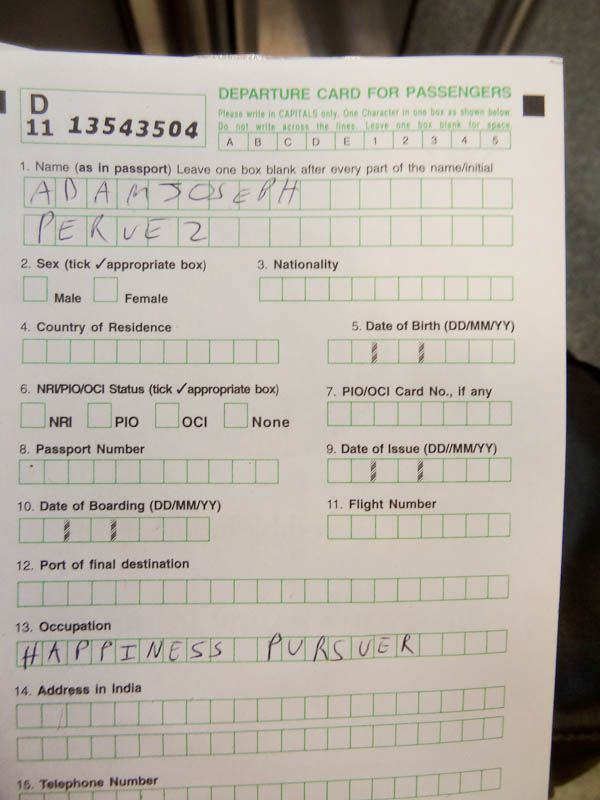

In [3]:
Image(filename='files/form9.jpg')

### With 4 degrees

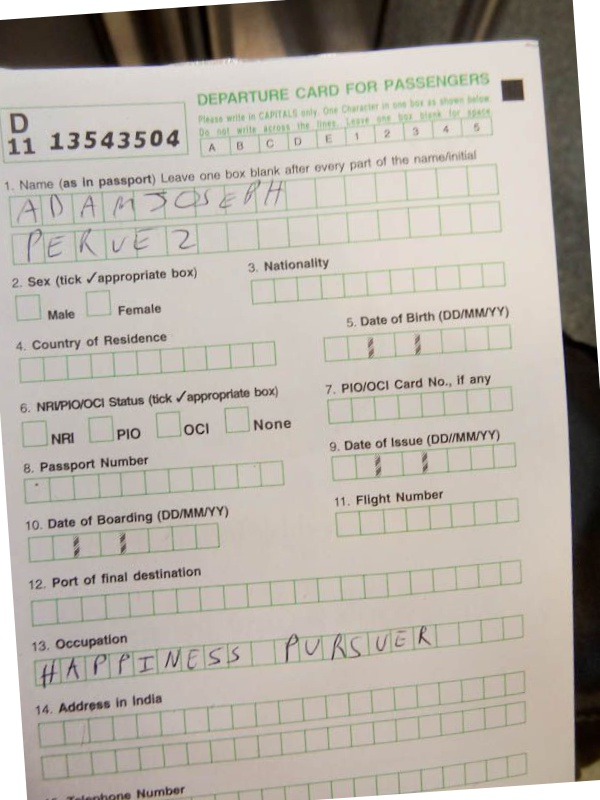

In [4]:
Image(filename='files/p4_form9.jpg')

### Corrected image

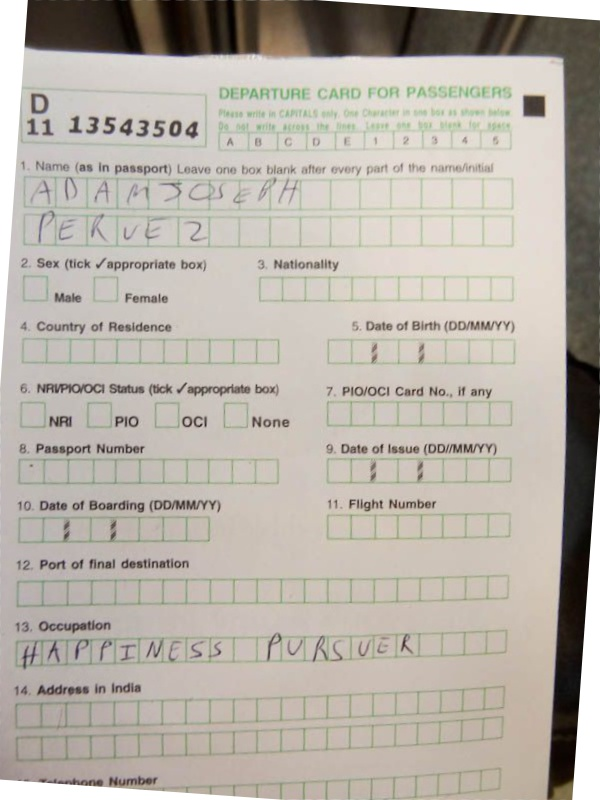

In [5]:
Image(filename='results/r_-4_p4_form9.jpg')

### With 9 degrees

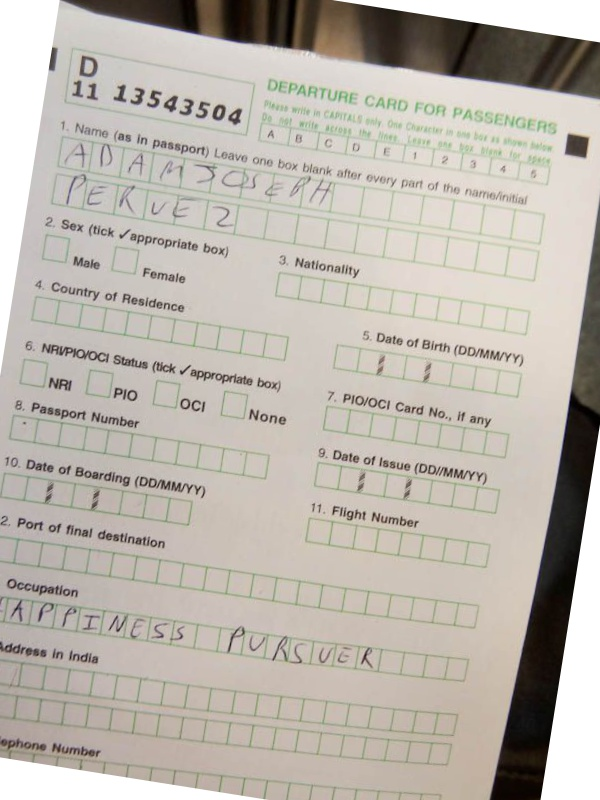

In [6]:
Image(filename='files/m9_form9.jpg')

### Corrected image

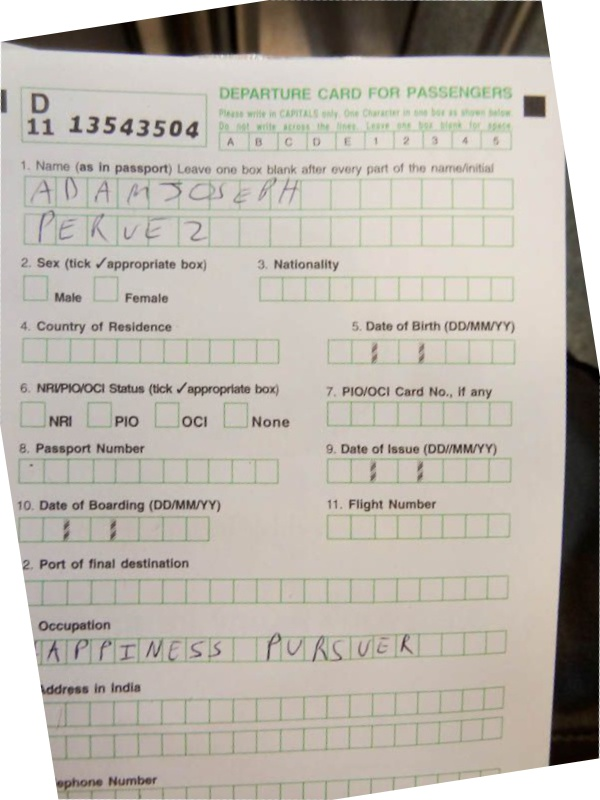

In [7]:
Image(filename='results/r_8_m9_form9.jpg')